Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Srilanka Floods Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/srilanka_floods_2017_train.tsv"
dev_path = "/content/srilanka_floods_2017_dev.tsv"
test_path = "/content/srilanka_floods_2017_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,870161518553251840,"RT @TakasSriLanka: #FloodSL Update: Rs. 1,002,...",rescue_volunteering_or_donation_effort
1,873498581344419840,"RT @japan_lanka: During their stay, the Expert...",rescue_volunteering_or_donation_effort
2,873648602345861120,"Sri Lanka public helping flood victims, One of...",rescue_volunteering_or_donation_effort
3,877815909334822912,#UNICEF rep for #SriLanka @TimSuttonUNICEF in ...,other_relevant_information
4,877838559696367616,RT @TimSuttonUNICEF: #unicef Sri Lanka and #no...,rescue_volunteering_or_donation_effort
...,...,...,...
444,871709803881607168,Cyclone Mora then smashed into Bangladesh &amp...,infrastructure_and_utility_damage
445,870067496925016066,RT @dmc_lk: Situation on the National Roads #3...,infrastructure_and_utility_damage
446,875016238681948161,Heres what were doing to help thousands of #an...,rescue_volunteering_or_donation_effort
447,870309873023668224,RT @TrustYourTiming: Pres appoints 24Ministers...,other_relevant_information


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,870476406009942016,RT @ChandruLk: China announces emergency human...,rescue_volunteering_or_donation_effort
1,870186795547471872,400 #FloodSL victims in dnkoluwaththa in Pitab...,requests_or_urgent_needs
2,872058574146596865,RT @Ali_answers: #PakistanNavy providing relie...,rescue_volunteering_or_donation_effort
3,870318925841551363,RT @RasmilaD: Death toll increased to 206; 92 ...,injured_or_dead_people
4,870259920695734272,Thailand donates B2m to help flood-stricken Sr...,rescue_volunteering_or_donation_effort
...,...,...,...
106,870427829045010432,RT @jscarto: Severe flooding in #SriLanka seen...,caution_and_advice
107,870285573583273984,"Sri Lankans, young and old without and race di...",sympathy_and_support
108,874530502870528000,#PhotoOfTheDay: Capt. McPherson of #USSLakeEri...,other_relevant_information
109,871416115213324292,RT @sulorammohan: Medical aid for #Flood vict...,requests_or_urgent_needs


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
rescue_volunteering_or_donation_effort,319
other_relevant_information,56
injured_or_dead_people,46
sympathy_and_support,40
requests_or_urgent_needs,34
caution_and_advice,28
not_humanitarian,20
infrastructure_and_utility_damage,17


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

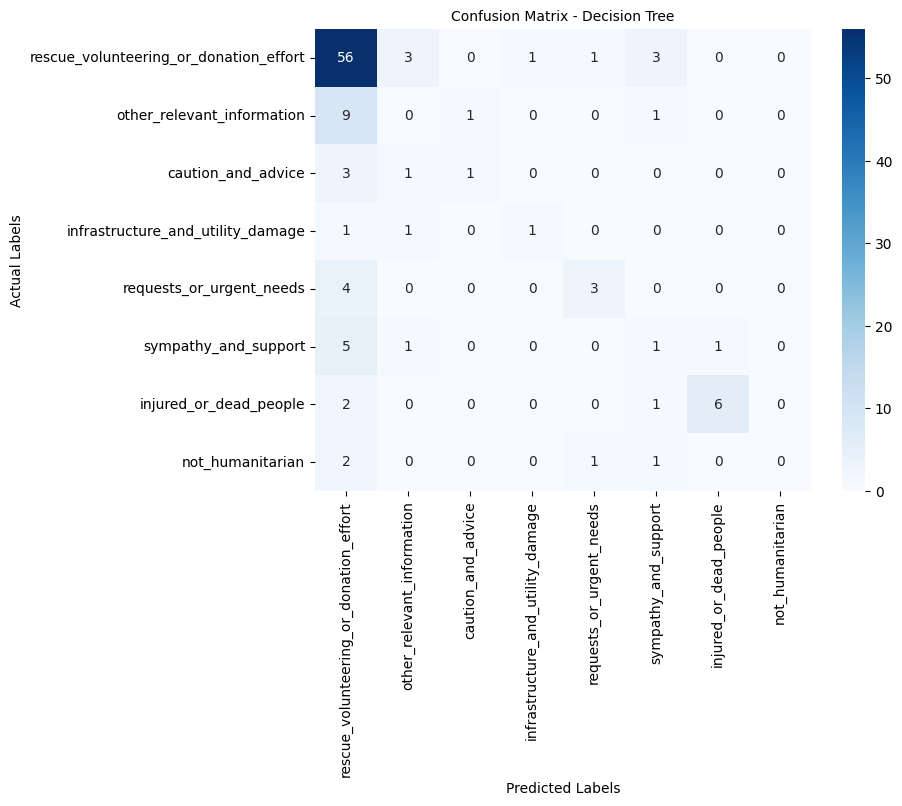


Decision Tree Evaluation:
Accuracy: 0.6126126126126126
Precision: 0.5474275669397621
F1 Score: 0.5679380946504234

 Classification Report:
                                        precision    recall  f1-score   support

rescue_volunteering_or_donation_effort       0.68      0.88      0.77        64
            other_relevant_information       0.00      0.00      0.00        11
                    caution_and_advice       0.50      0.20      0.29         5
     infrastructure_and_utility_damage       0.50      0.33      0.40         3
              requests_or_urgent_needs       0.60      0.43      0.50         7
                  sympathy_and_support       0.14      0.12      0.13         8
                injured_or_dead_people       0.86      0.67      0.75         9
                      not_humanitarian       0.00      0.00      0.00         4

                              accuracy                           0.61       111
                             macro avg       0.41      0.3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

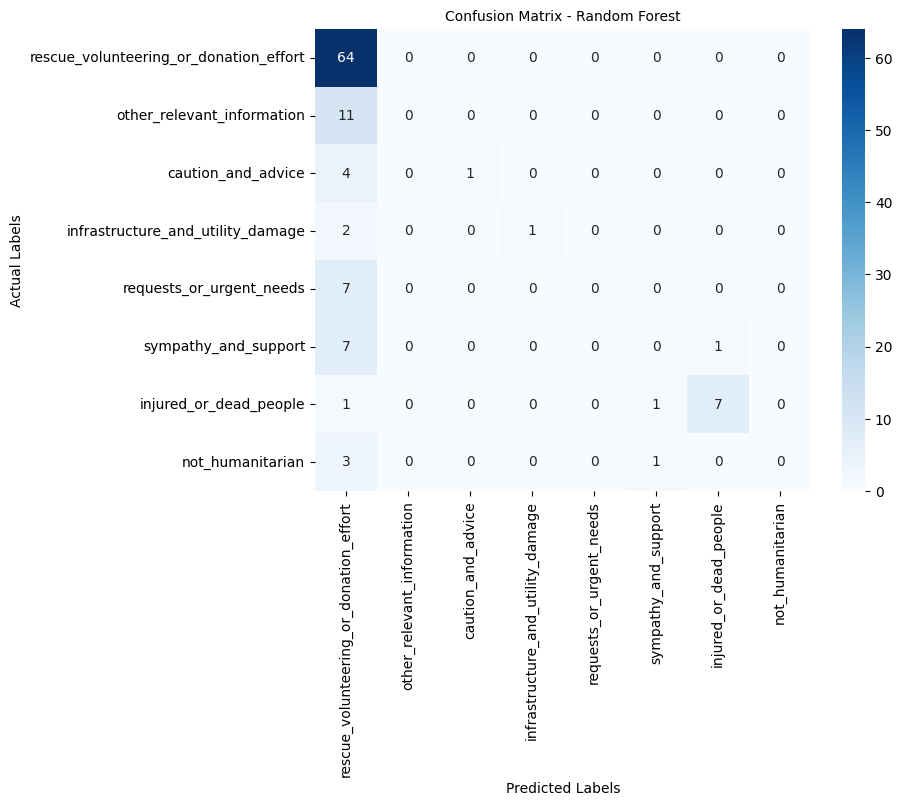


Random Forest Evaluation:
Accuracy: 0.6576576576576577
Precision: 0.5157543907543908
F1 Score: 0.5480729737315807

 Classification Report:
                                        precision    recall  f1-score   support

rescue_volunteering_or_donation_effort       0.65      1.00      0.79        64
            other_relevant_information       0.00      0.00      0.00        11
                    caution_and_advice       1.00      0.20      0.33         5
     infrastructure_and_utility_damage       1.00      0.33      0.50         3
              requests_or_urgent_needs       0.00      0.00      0.00         7
                  sympathy_and_support       0.00      0.00      0.00         8
                injured_or_dead_people       0.88      0.78      0.82         9
                      not_humanitarian       0.00      0.00      0.00         4

                              accuracy                           0.66       111
                             macro avg       0.44      0.2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

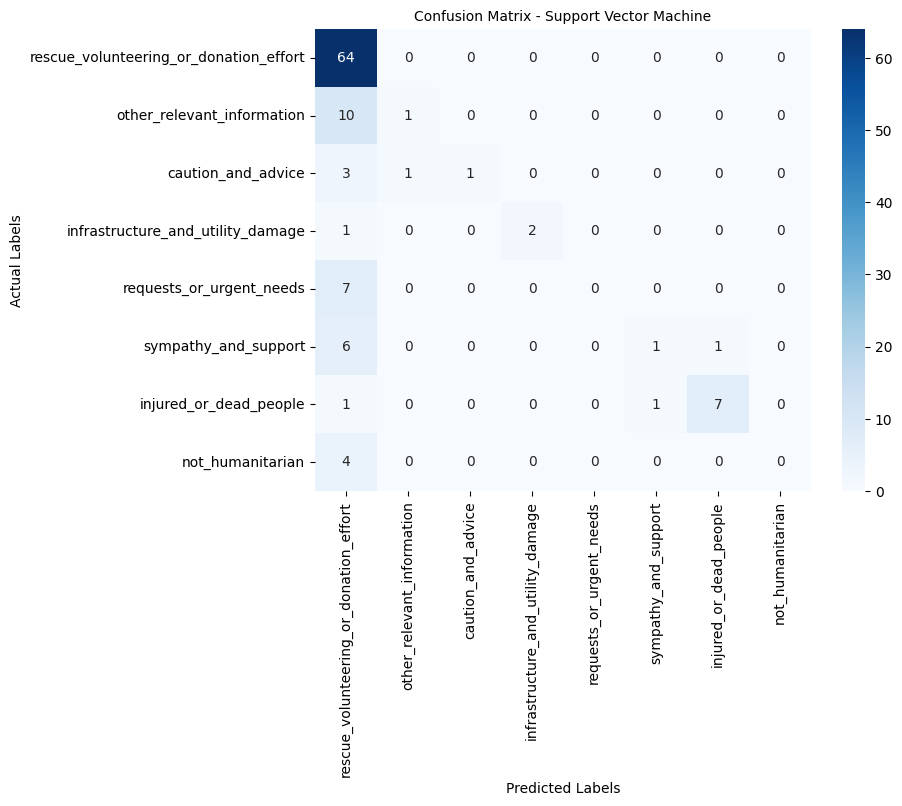


Support Vector Machine Evaluation:
Accuracy: 0.6846846846846847
Precision: 0.6129879879879879
F1 Score: 0.5943309825662767

 Classification Report:
                                        precision    recall  f1-score   support

rescue_volunteering_or_donation_effort       0.67      1.00      0.80        64
            other_relevant_information       0.50      0.09      0.15        11
                    caution_and_advice       1.00      0.20      0.33         5
     infrastructure_and_utility_damage       1.00      0.67      0.80         3
              requests_or_urgent_needs       0.00      0.00      0.00         7
                  sympathy_and_support       0.50      0.12      0.20         8
                injured_or_dead_people       0.88      0.78      0.82         9
                      not_humanitarian       0.00      0.00      0.00         4

                              accuracy                           0.68       111
                             macro avg       0.57

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")